In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
os.chdir("..")

### Read and display the data

In [3]:
def read_data():
    filename = 'data/pima-indians-diabetes.csv'
    dataset = pd.read_csv(filename, header=None)
    dataset.columns = [
        "NumTimesPrg", "PlGlcConc", "BloodP",
        "SkinThick", "TwoHourSerIns", "BMI",
        "DiPedFunc", "Age", "HasDiabetes"]

    return dataset

In [15]:
data = read_data()
data.head()

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [26]:
print()

[  6.    148.     72.     35.      0.     33.6     0.627  50.   ]


### Train Simple NN on this dataset and measure accuracy

In [195]:
class SimpleNN(nn.Module):
    def __init__(self, n_input, n_hidden=[20,20], n_output=1):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden[0])
        self.hidden2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.output = nn.Linear(n_hidden[1], n_output)
        
    def forward(self, x):
        """ Accepts input of shape (N_objects, n_input) """
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.sigmoid(x)
        return x

In [196]:
# Example of applying classifier to very simple object
classifier = SimpleNN(8)
x = torch.from_numpy(np.array([data.values[1][:8]], dtype=np.float32))
output = classifier(x)
output > 0.5

tensor([[0]], dtype=torch.uint8)

In [226]:
# Divide dataset into training, validation and test datasets
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)
train_data.head()

X_train, y_train = np.array(train_data.values[:, :8], dtype=np.float32), np.array(train_data.values[:, 8], dtype=np.float32)
X_val, y_val = np.array(val_data.values[:, :8], dtype=np.float32), np.array(val_data.values[:, 8], dtype=np.float32)
X_test, y_test = np.array(test_data.values[:, :8], dtype=np.float32), np.array(test_data.values[:, 8], dtype=np.float32)

mean, std = X_train.mean(axis=0), X_train.std(axis=0)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

X_train, X_val, X_test = torch.from_numpy(X_train), torch.from_numpy(X_val), torch.from_numpy(X_test)
y_train, y_val, y_test = torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(y_test)

print(X_train)

tensor([[ 2.4351, -1.0748,  0.2312,  ...,  0.3912, -0.2916,  1.2579],
        [ 0.0360, -1.2362,  0.8921,  ..., -0.3957, -0.4932,  0.0680],
        [ 0.6358, -1.3331,  0.5616,  ...,  0.9813, -0.9557, -0.4419],
        ...,
        [ 0.0360, -0.2354, -0.2645,  ..., -1.3662, -0.1132,  0.3230],
        [ 0.6358, -0.4291, -1.4211,  ..., -1.0908,  1.1456,  0.1530],
        [ 1.5354,  0.2811,  0.0109,  ...,  0.2469,  0.6137,  1.0029]])


In [228]:
# Train SimpleNN
model = SimpleNN(8)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=3e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=1e-2)
loss = nn.BCELoss()

n_epochs = 2000
for epoch in range(n_epochs):
    model.zero_grad()
    output = model(X_train)
    cost = loss(output, y_train)
    cost.backward()
    optimizer.step()
    if epoch % 100 == 0:
        val_output = model(X_val)
        val_loss = loss(val_output, y_val)
        val_acc = np.mean((val_output >= 0.5).view(-1).numpy() == y_val.numpy())
        print(cost.item(), val_loss.item(), val_acc)

0.6617212295532227 0.644692599773407 0.7560975609756098
0.6034566760063171 0.571409285068512 0.7642276422764228
0.5381165742874146 0.4987359941005707 0.8292682926829268
0.496216356754303 0.45290252566337585 0.8373983739837398
0.47876080870628357 0.43546053767204285 0.8211382113821138
0.46972140669822693 0.4296903908252716 0.8292682926829268
0.4639057219028473 0.4282130300998688 0.8211382113821138
0.4593995213508606 0.4276420772075653 0.8211382113821138
0.45582473278045654 0.42795178294181824 0.8211382113821138
0.4529078006744385 0.42983946204185486 0.8211382113821138
0.4503971338272095 0.4318242073059082 0.8292682926829268
0.44833454489707947 0.4337247610092163 0.8211382113821138
0.4466778337955475 0.4352792203426361 0.8211382113821138
0.445246160030365 0.43674004077911377 0.8211382113821138
0.44381165504455566 0.4379292130470276 0.8211382113821138
0.44235900044441223 0.4384967088699341 0.8292682926829268
0.44086921215057373 0.4391334354877472 0.8373983739837398
0.439521849155426 0.440

In [230]:
test_output = model(X_test)
test_acc = np.mean((test_output >= 0.5).view(-1).numpy() == y_test.numpy())
print(f"Accuracy on test dataset: {test_acc}")

Accuracy on test dataset: 0.7727272727272727


Accuracy on test dataset ~77.2%, which is pretty good, now we can use this model

### Generate set of counterfactuals

In [236]:
# Choose K elements which have class=target_class according to our model
def choose_K_elements(model, data, K=10, target_class=1):
    output = model(data).view(-1)
    indices = []
    cur_ind = 0
    while cur_ind < len(output) and len(indices) < K:
        out = 1 if output[cur_ind] >= 0.5 else 0
        if out == target_class:
            indices.append(cur_ind)
        cur_ind += 1
    
    return data[indices, :]

In [248]:
# Choose 10 objects and display them
X_has_diabetes = choose_K_elements(model, X_train, K=10)
print(X_has_diabetes)
print(model(X_has_diabetes))

tensor([[ 1.2356,  1.0881, -0.4297,  0.3570,  4.0008,  0.2207,  0.2535,  1.0879],
        [ 1.5354,  1.3787,  0.4515, -1.3104, -0.7245,  0.0633, -1.0516,  1.0029],
        [ 0.9357,  0.2488, -0.0993,  1.8319,  0.4688,  0.8108, -0.0901,  0.8329],
        [ 0.0360,  0.8299,  0.2312,  0.2928,  2.0725,  0.3387, -0.2685, -0.2719],
        [ 2.1352,  0.7007,  1.3327,  0.8059,  0.6692,  0.5616, -0.7013,  1.5129],
        [ 0.0360,  2.1857,  2.2139,  0.6776, -0.7245, -0.5006,  0.7062,  0.3230],
        [ 2.4351,  0.6039,  0.8370,  0.8059, -0.7245,  0.6666, -0.7344,  0.6630],
        [ 0.0360,  0.7330, -0.6500,  0.4852,  0.6120, -0.3695, -0.5923,  0.3230],
        [ 0.0360,  1.6047,  0.1210, -1.3104, -0.7245,  1.4797,  0.0421, -0.6119],
        [ 0.6358,  2.3794,  0.0109, -1.3104, -0.7245, -0.1859, -0.4568, -0.1869]])
tensor([[0.7332],
        [0.7052],
        [0.6755],
        [0.5445],
        [0.6479],
        [0.7842],
        [0.6691],
        [0.5666],
        [0.8300],
        [0.7882]]

Cost function:
$$
\frac{1}{n}[\sum_{i=1}^n f_{target}(x_i + t_i) + \lambda \sum_{i=1}^n norm(t_i) + \mu \sum_{i=1}^n \sum_{j=1}^n d(t_i, t_j)],
$$

where
* $f_{target}$ - output of model
* $x_i$ - input datapoint
* $t_i$ - transformation applied to $x_i$
* $norm$ - function to constraint $t_i$ (e.g. L1 norm)
* $d$ - distance between two tranformations (e.g. L2 distance)

In [285]:
# Define and evaluate cost function on the dataset
def cost_func(model, X_data, ts, norm_func, dist_func, lambda_coef=1.0, mu_coef=1.0, verbose=True):
    term1 = torch.mean(model(X_data + ts))
    term2 = norm_func(ts)
    term3 = 0.0
    for i in range(ts.shape[0]):
        for j in range(i, ts.shape[0]):
            term3 += dist_func(ts[i], ts[j])
            
    if verbose:
        print("Terms:", term1.item(), lambda_coef * term2.item(), mu_coef * term3.item())
        
    return term1 + lambda_coef * term2 + mu_coef * term3

ts = torch.zeros_like(X_has_diabetes, requires_grad=True)
print(cost_func(model, X_has_diabetes, ts, norm_func=lambda x: torch.norm(x, p=1), dist_func=lambda x, y: torch.dist(x, y, p=2)))

cost_short = lambda t, l=1.0, mu=1.0, verb=True: cost_func(model, 
                                                           X_has_diabetes, 
                                                           t, 
                                                           norm_func=lambda x: torch.norm(x, p=1), 
                                                           dist_func=lambda x, y: torch.dist(x, y, p=2), 
                                                           lambda_coef=l, 
                                                           mu_coef=mu, 
                                                           verbose=verb)
print(cost_short(ts))

Terms: 0.6944345235824585 0.0 0.0
tensor(0.6944, grad_fn=<AddBackward0>)
Terms: 0.6944345235824585 0.0 0.0
tensor(0.6944, grad_fn=<AddBackward0>)


#### Experiment 1. LR=0.1, lambda_coef=0, mu_coef=0

In [310]:
ts = torch.zeros_like(X_has_diabetes, requires_grad=True)

lr = 0.1
lambda_coef = 0.0
mu_coef = 0
optimizer = torch.optim.SGD([ts], lr=lr)

n_iters = 1000
for i in range(n_iters):
    optimizer.zero_grad()
    cost = cost_short(ts, l=lambda_coef, mu=mu_coef, verb=False)
    cost.backward()
    optimizer.step()
    if i % 300 == 0:
        print(cost_short(ts, l=lambda_coef, mu=mu_coef, verb=True).item())

Terms: 0.6941248774528503 0.0 0.0
0.6941248774528503
Terms: 0.5813257694244385 0.0 0.0
0.5813257694244385
Terms: 0.4490535855293274 0.0 0.0
0.4490535855293274
Terms: 0.35352247953414917 0.0 0.0
0.35352247953414917


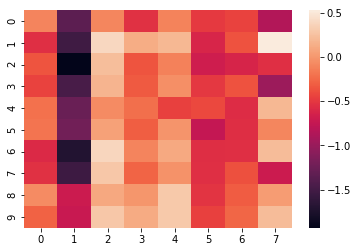

In [311]:
sns.heatmap(ts.detach().numpy())

#### Experiment 2. LR=0.1, lambda_coef=0.005, mu_coef=0

In [303]:
ts = torch.zeros_like(X_has_diabetes, requires_grad=True)

lr = 0.1
lambda_coef = 0.005
mu_coef = 0
optimizer = torch.optim.SGD([ts], lr=lr)

n_iters = 5000
for i in range(n_iters):
    optimizer.zero_grad()
    cost = cost_short(ts, l=lambda_coef, mu=mu_coef, verb=False)
    cost.backward()
    optimizer.step()
    if i % 300 == 0:
        print(cost_short(ts, l=lambda_coef, mu=mu_coef, verb=True).item())

Terms: 0.6941248774528503 0.00017442669719457625 0.0
0.6942992806434631
Terms: 0.6493395566940308 0.015986053943634032 0.0
0.6653255820274353
Terms: 0.5717087984085083 0.038029747009277345 0.0
0.6097385287284851
Terms: 0.5054576396942139 0.05860831260681153 0.0
0.5640659332275391
Terms: 0.4519956707954407 0.07454482555389405 0.0
0.5265405178070068
Terms: 0.40791550278663635 0.08799716949462891 0.0
0.49591267108917236
Terms: 0.3621148467063904 0.10155619621276855 0.0
0.4636710286140442
Terms: 0.3127034604549408 0.11481551170349122 0.0
0.42751896381378174
Terms: 0.2708316743373871 0.1255318546295166 0.0
0.3963635265827179
Terms: 0.24608495831489563 0.1334278964996338 0.0
0.37951284646987915
Terms: 0.23513348400592804 0.13762975692749024 0.0
0.3727632164955139
Terms: 0.2230086624622345 0.14162744522094728 0.0
0.3646361231803894
Terms: 0.21651379764080048 0.14405132293701173 0.0
0.3605651259422302
Terms: 0.21039709448814392 0.14591747283935547 0.0
0.3563145697116852
Terms: 0.20391270518302

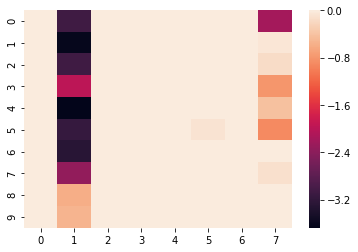

In [307]:
sns.heatmap(ts.detach().numpy())